# Kaggle-Tutorial

## Time Series

---

## 추세Trand

이동 평균과 time dummy를 사용한 장기 변화 모델링

원본: [Trand](https://www.kaggle.com/ryanholbrook/trend)

---
### 추세Trand란?

시계열의 **추세Trand** 구성 요소componet는 계열 평균의 지속적이고 장기적인 변화를 나타냅니다. 추세는 시리즈에서 가장 느리게 움직이는 부분으로 가장 큰 중요도를 나타내는 부분입니다. 제품 판매의 시계열에서 증가 추세는 해마다 제품에 대해 더 많은 사람들이 알게 됨이 시장 확장에 영향을 준것으로 볼 수 있습니다.

![Trend patterns in four time series.](https://i.imgur.com/ZdS4ZoJ.png)

이 과정에서는 평균의 추세에 중점을 둘 것이다. 그러나 더 일반적으로 시계열에서 지속적이고 느리게 움직이는 변화는 추세를 구성할 수 있다. 실제로 시계열에는 일반적으로 변동 추세가 있다.

### 이동 평균 플롯

시계열에 어떤 종류의 추세가 있는지 확인하기 위해 **이동 평균 플롯**을 사용할 수 있다. 시계열의 이동 평균을 계산하기 위해, 우리는 어떤 정의된 너비의 슬라이딩 창 내에서 값들의 평균을 계산합니다. 그래프의 각 점은 양쪽 창에 속하는 계열의 모든 값 평균을 나타냅니다. 아이디어는 시리즈의 모든 단기 변동을 완화하여 장기적인 변화만 남도록 하는 것입니다.

![A moving average plot illustrating a linear trend. Each point on the curve (blue) is the average of the points (red) within a window of size 12.](https://i.imgur.com/EZOXiPs.gif)

위의 *Mauna Loa* 시리즈가 해마다 위아래로 반복되는 움직임, 즉 단기적인 *계절적* 변화에 주목하라. 변화가 추세의 일부가 되려면 계절적 변화보다 더 오랜 기간에 걸쳐 발생해야 합니다. 따라서 추세를 시각화하기 위해 시리즈의 어떤 계절 기간보다 긴 기간에 대한 평균을 취합니다. *Mauna Loa* 시리즈의 경우 매년 시즌을 매끄럽게 하기 위해 크기 12의 창을 선택했습니다.

### 추세 설계Engineering

추세의 모양을 식별하게되면 time-step feature를 사용하여 모델링을 해볼 수 있다. 우리는 이미 time dummy를 사용한 선형 추세 모델링의 방벙을 보았었다:

`target = a * time + b`

우리는 time dummy의 변환을 통해 다른 많은 종류의 추세를 맞춰볼 수 있다. 추세가 2차 방정식(포물선)으로 나타나면, feature set에 time dummy의 제곱을 추가해 주기만 하면 된다.

`target = a * time ** 2 + b * time + c`

선형회귀에서 계수 `a`, `b` 그리고 `c` 에대해서 배울 것이다.

아래 그림의 추세 곡선은 이러한 종류의 features와 scikit-learn의 `LinearRegression`을 사용하여 맞추었다

![Cars Sold in Quebec](https://i.imgur.com/KFYlgGm.png)

<center>위: 선형 추세 시리즈. Below: 2차 방정식 형태의 추세 시리즈</center>

이전에 이런 트릭을 본적이 없다면, 선형회귀가 선 이외의 곡선에 맞을 수 있다는 것을 깨닫지 못했을 것이다. 이 아이디어는 적절한 모양의 곡선을 제공할 수 있는 기능이 있을 때, 선형회귀가 목표에 가장 잘 맞는 방식으로 이들을 결합하는 방법을 배울 수 다는 것이다.

### 예제 - 터널 트래픽
이 예제에서는 *터널 트래픽* 데이터셋에 대한 추세 모델을 생성할 것이다.

In [1]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

simplefilter("ignore")  # ignore warnings to clean up output cells

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# Load Tunnel Traffic dataset
data_dir = Path("./input/ts-course-data")
tunnel = pd.read_csv(data_dir / "tunnel.csv", parse_dates=["Day"])
tunnel = tunnel.set_index("Day").to_period()


이 시리즈가 어떤 추세를 가지고 있는지 알아보기위해 이동 평균 플롯을 만들어보자. 이 시리즈에는 매일의 관찰데이터가 있으므로 365일의 윈도우(기간)를 선택하면 1년 내의 단기 변화를 매끄럽 처리해보자.

이동 평균을 만들려면, 먼저 `rolling` 메서드를 사용하여 윈도우에 대한 계산을 한다. 그리고 이어 `mean`메서드로 윈도우 내 항목들에대한 평균을 계산한다. 보다시피 *터널 트래픽*의 추세는 선형에 가깝니다.

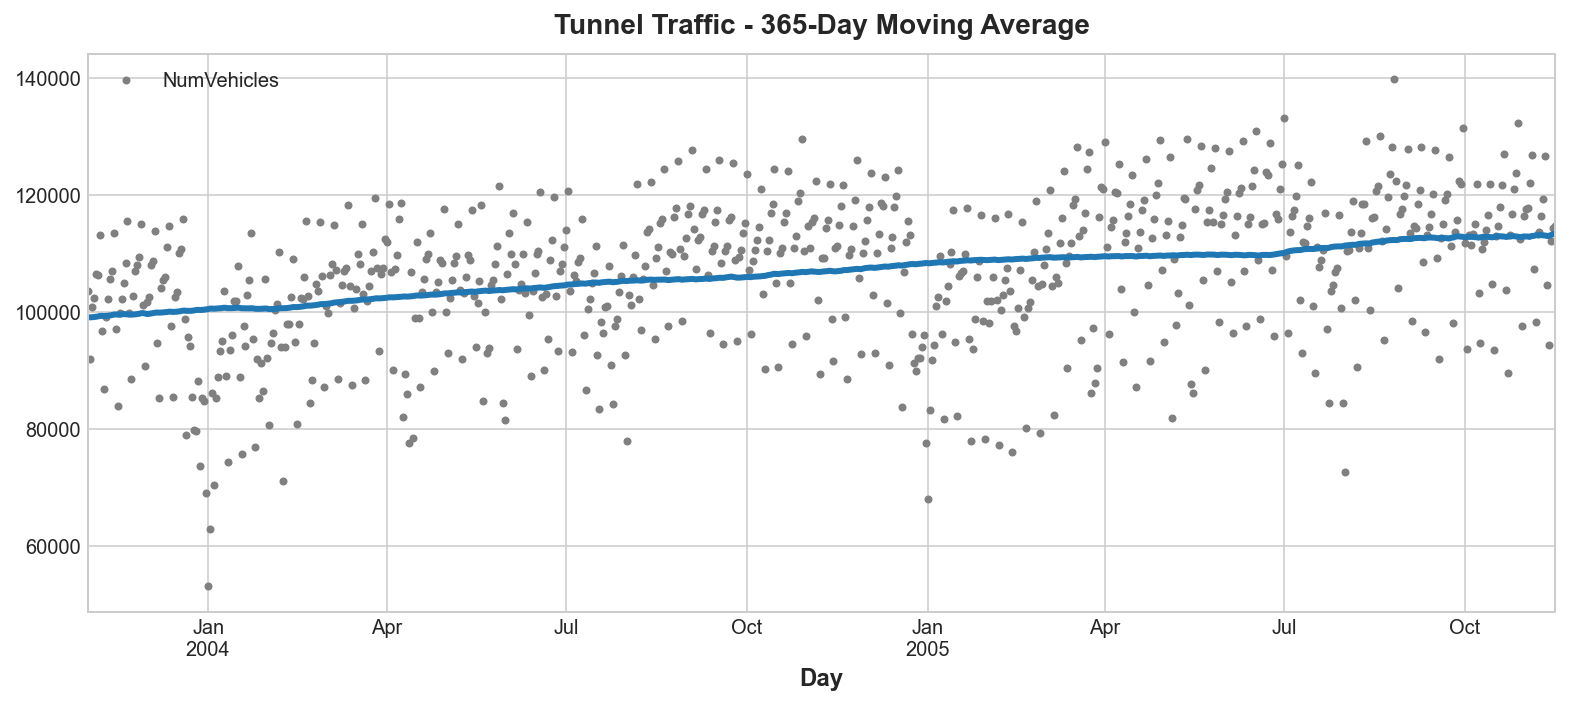

In [2]:
moving_average = tunnel.rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = tunnel.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Tunnel Traffic - 365-Day Moving Average", legend=False,
);

1과에서 우리는 Pandas에서 직접 time dummy를 설계했다.그러나 지금부터는 `statsmodels`라이브러리의 `DeterministicProcess`라고 불리는 기능을 사용할 것이다. 이 기능을 이용하면, 시계열 및 선형 회귀에서 발생할 수 있는 까다로운 실패사례를 피하는데 도움이 된다. `order` 인수argument는 다항식의 차수를 나타낸다: `1`은 선형Linear, `2`는 2차 방정식quadratic, `3`은 3차 방정식cubic 등.

In [4]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=tunnel.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

,const,trend
Day,,
2003-11-01,1.0,1.0
2003-11-02,1.0,2.0
2003-11-03,1.0,3.0
2003-11-04,1.0,4.0
2003-11-05,1.0,5.0


(*Deterministic Process*는 `const`와 `추세` 시리즈와 같이 무작위가 아니거나 완전히 *결정된deterministic* 시계열에 대한 기술용어이다. 시간 인텍스에서 파생된 feature들은 일반적으로 결정된 성격deterministic이다.)

`fit_intercept=False `인수가 추가되었지만, 기본적으로 이전과 같이 추세모델을 만든다.

In [5]:
from sklearn.linear_model import LinearRegression

y = tunnel["NumVehicles"]  # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

`LinearRegression` 모델에 의해 발견된 추세는 이동 평균 플롯과 거의 동일하며, 이는 이 경우에 사용된 선형 추세가
올바른 결정이었음을 시사한다.

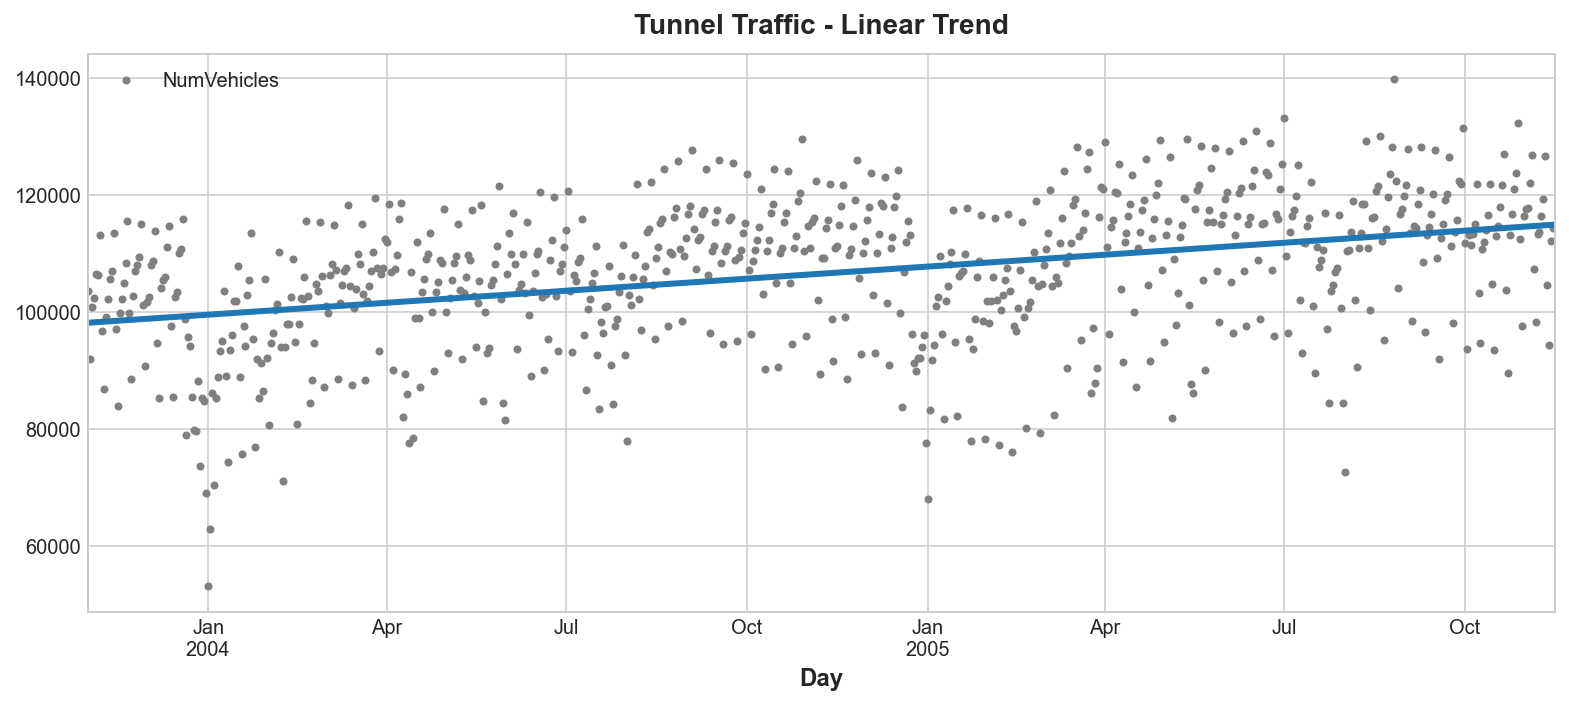

In [6]:
ax = tunnel.plot(style=".", color="0.5", title="Tunnel Traffic - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

예측을 만들기 위해 우리는 우리의 모델을 "샘플 외" 데이터에 적용한다. "샘플 외" 데이터는 훈련데이더의 관찰기간을 벗어난 시간을 나타낸다. 30일 예측을 하는 방법은 다음과 같다.

In [7]:
X = dp.out_of_sample(steps=30)

y_fore = pd.Series(model.predict(X), index=X.index)

y_fore.head()

2005-11-17    114981.801146
2005-11-18    115004.298595
2005-11-19    115026.796045
2005-11-20    115049.293494
2005-11-21    115071.790944
Freq: D, dtype: float64

다음 30일동안의 추세를 예측해보기 위해 시리즈의 일부를 플로팅해보자

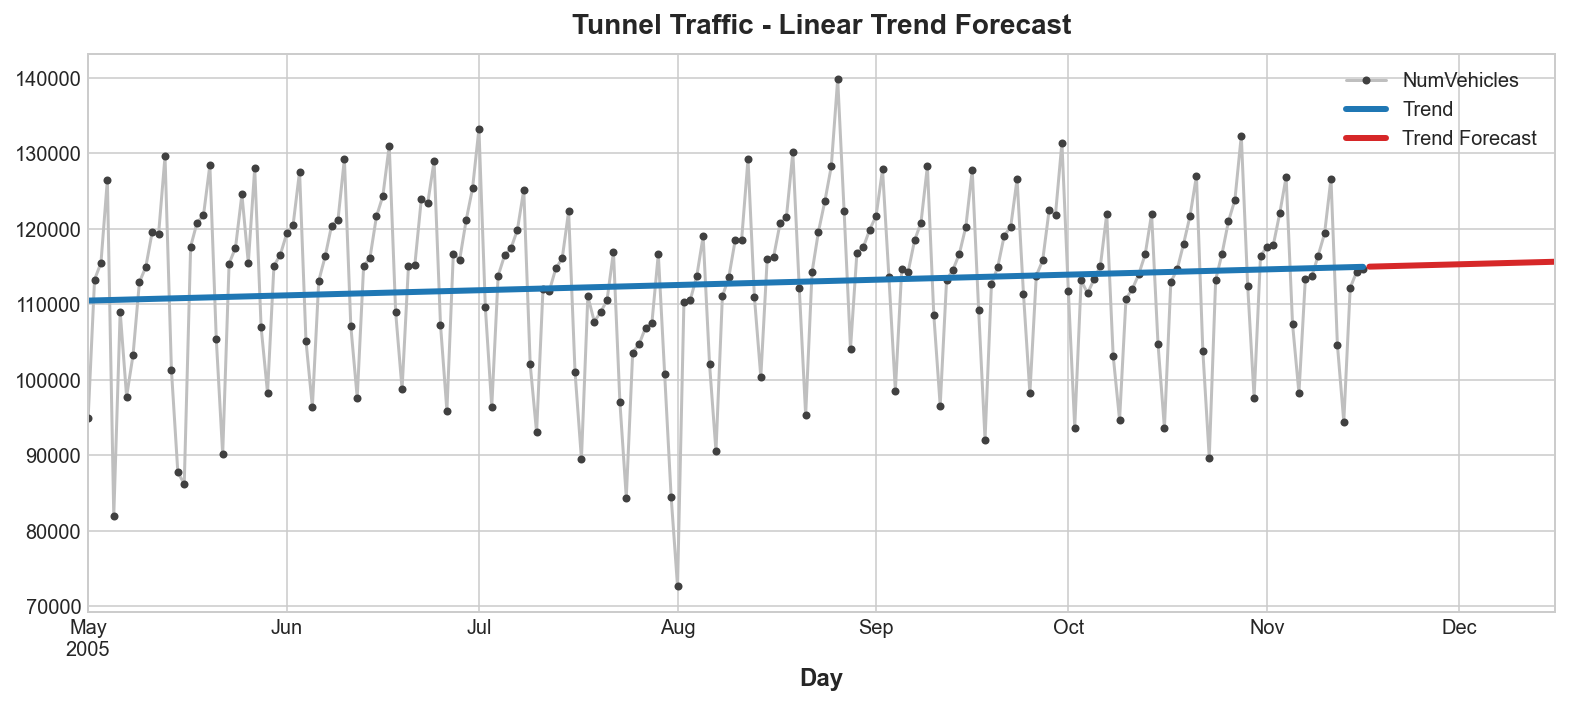

In [8]:
ax = tunnel["2005-05":].plot(title="Tunnel Traffic - Linear Trend Forecast", **plot_params)
ax = y_pred["2005-05":].plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()

이 장에서 배운 추세 모델은 여러가지이유로 유용한 것으로 드러난다. 보다 정교한 모델을 위해서 기준선 또는 시작점의 액팅외에도, 추세를 학습하는 것이 불가능한 알고리즘에는 "하이브리드 모델"의 구성요소를 사용할 수 있다(예를 들어 XGBoost와 랜덤 포레스트). 5장에서 이 기숭에 대해 좀 더 자세리 알아보겠다.

### 당신의 차례
[Model trend in Store Sale](https://www.kaggle.com/kernels/fork/19616015)를 수행하며 고차 방정식으로 예측하는 것에 대한 위험성을 이해하자.